# Machine Learning Decal, Spring 2018
## Day 3: Linear Regression

In [1]:
import pandas as pd 
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression
from sklearn import datasets
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error

### NBA Salary Data

In [2]:
nba_sals = pd.read_csv("./nbasalary.csv", index_col = 0)
nba_sals = nba_sals.dropna(axis=0)
nba_sals.head()

FileNotFoundError: [Errno 2] File b'./nbasalary.csv' does not exist: b'./nbasalary.csv'

In [8]:
log_wage = nba_sals["lwage"]
wage = nba_sals["wage"]
points = nba_sals["points"]
exper = nba_sals["exper"]

### Simple Linear Regression

##### In this section, we will compare two SLR models and see which one performs better on a validation set. 
##### Model 1: Regressing wage on points scored
##### Model 2: Regressing wage on years of experience

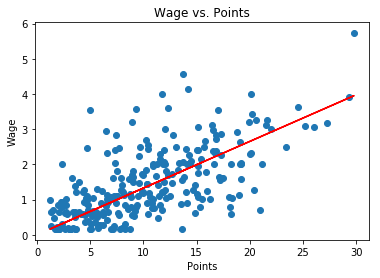

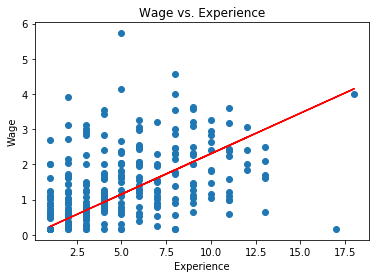

In [9]:
plt.figure()
plt.title("Wage vs. Points")
plt.xlabel("Points")
plt.ylabel("Wage")
plt.scatter(points,wage)
myOLS_points = sm.OLS(wage,points).fit()
plt.plot(points, myOLS_points.predict(points), color = 'red')

plt.figure()
plt.title("Wage vs. Experience")
plt.xlabel("Experience")
plt.ylabel("Wage")
plt.scatter(exper,wage)
myOLS_exper = sm.OLS(wage,exper).fit()
plt.plot(exper, myOLS_exper.predict(exper), color = 'red')

plt.show()

#### A little validation...

In [10]:
wage_train = nba_sals["wage"][0:214]
wage_valid = nba_sals["wage"][214:]
points_train = nba_sals["points"][0:214]
points_valid = nba_sals["points"][214:]
exper_train = nba_sals["exper"][0:214]
exper_valid = nba_sals["exper"][214:]

#### Regression wage on points...

In [11]:
myOLS = sm.OLS(wage_train,points_train).fit()
wage_hat = myOLS.predict(points_valid)
mse = np.linalg.norm(wage_valid - wage_hat)**2/len(wage_valid)
print("The MSE for the model wage~points is:", mse)

The MSE for the model wage~points is: 0.4486534570325539


#### Regressing wage on experience...

In [12]:
myOLS = sm.OLS(wage_train,exper_train).fit()
wage_hat = myOLS.predict(exper_valid)
mse = np.linalg.norm(wage_valid - wage_hat)**2/len(wage_valid)
print("The MSE for the model wage~experience is:", mse)

The MSE for the model wage~experience is: 0.5514868385039052


##### Conclusion: points scored is a better predictor of wage than years of experience

### Multiple Linear Regression

#### Wage vs. Experience & Points

In [13]:
exp_dat = nba_sals[["exper","points"]]
exp_dat = sm.add_constant(exp_dat)
myMLR = sm.OLS(wage, exp_dat).fit()
myMLR.summary()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   wage   R-squared:                       0.516
Model:                            OLS   Adj. R-squared:                  0.512
Method:                 Least Squares   F-statistic:                     141.3
Date:                Mon, 11 Feb 2019   Prob (F-statistic):           1.71e-42
Time:                        15:15:50   Log-Likelihood:                -282.14
No. Observations:                 268   AIC:                             570.3
Df Residuals:                     265   BIC:                             581.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0537      0.099     -0.540      0.590      -0.249       0.142
exper          0.0866      0.013      6.786      0.000       0.061       0.112
points         0.1016      0.007     13.822      0.000       0.087       0.116
==============================================================================
Omnibus:                       38.136   Durbin-Watson:                   1.821
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               66.078
Skew:                           0.794   Prob(JB):                     4.48e-15
Kurtosis:                       4.844   Cond. No.                         30.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

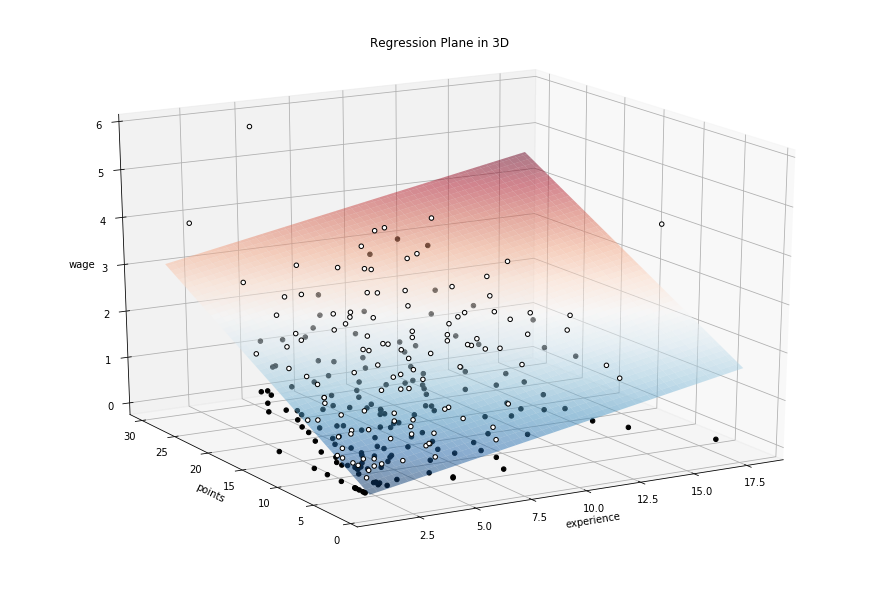

In [14]:
from mpl_toolkits.mplot3d import Axes3D

x1, x2 = np.meshgrid(np.linspace(exp_dat.exper.min(), exp_dat.exper.max(), 100), 
                       np.linspace(exp_dat.points.min(), exp_dat.points.max(), 100))

x3 = myMLR.params[0] + myMLR.params[1] * x1 + myMLR.params[2] * x2

# create matplotlib 3d axes
fig = plt.figure(figsize=(12, 8))
my3D = Axes3D(fig, azim=-120, elev=20)

# plot hyperplane
surf = my3D.plot_surface(x1, x2, x3, cmap=plt.cm.RdBu_r, alpha=0.5, linewidth=0.5)

# plot data points
resid = wage - myMLR.predict(exp_dat)
my3D.scatter(exp_dat[resid >= 0].exper, exp_dat[resid >= 0].points, wage[resid >= 0], color='black', alpha=1.0, facecolor='white')
my3D.scatter(exp_dat[resid < 0].exper, exp_dat[resid < 0].points, wage[resid < 0], color='black', alpha=1.0)

# set axis labels
my3D.set_xlabel('experience')
my3D.set_ylabel('points')
my3D.set_zlabel('wage')
my3D.set_title('Regression Plane in 3D')

plt.show()

### Polynomial Regression

We have our data with 2 independent variables - experience and points. Let's call them $\alpha_1$ and $\alpha_2$ for now.

So far, we have just been using the indep variables as features. So, our model was something like $$ h_{\theta}(\alpha) = \theta_0 + \theta_1*\alpha_1 + \theta_2*\alpha_2 $$

But what if we didn't want to have our features be just the variables? What if we wanted the features to be the square of the variables, or something more fancy? Such as this:

$$ h_{\theta}(\alpha) = \theta_0 + \theta_1*\alpha_1^2 + \theta_2*\alpha_2*\alpha_1 $$

In fact, this can very easily done with polynomial features. Every polynomial has a degree. The degree controls to what exponent the combined terms are. In fact, what we have been doing so far is creating polynomial features with degree d=1! Let's see what happens when d=2:

$$ h_{\theta}(\alpha) = \theta_0 + \theta_1*\alpha_1 + \theta_2*\alpha_2 + \theta_3*\alpha_1^2 + \theta_4*\alpha_2^2 + \theta_5*\alpha_1*\alpha_2 $$

What we see is we add more _cross terms_ of our features to create higher-order representations. Notice our model is still linear, though, since each $\theta$ is still only first degree (linear).

In [15]:
def poly_reg(x, y, degree = 1):
    # Add a bias term to the dataset
    x = sm.add_constant(x)
    
    # Create polynomial features
    poly_feats = PolynomialFeatures(degree)
    x = poly_feats.fit_transform(x)
    
    # Split into training and validation set
    split = int(0.8*x.shape[0])
    x_train, x_val = x[0:split, ], x[split:, ]
    y_train, y_val = y[:split, ], y[split:, ]
    
    # Fit the polynomial regression model
    my_reg = sm.OLS(y_train, x_train).fit()
    
    # Make predictions
    val_preds = my_reg.predict(x_val)
    train_preds = my_reg.predict(x_train)
    val_mse = mean_squared_error(y_val, val_preds)
    train_mse = mean_squared_error(y_train, train_preds)
    print("Degree:", degree, "\n", 
          "Train MSE:", train_mse, "\n", "Valid MSE:", val_mse) 
    
    return train_mse, val_mse

In [16]:
deg_list = [1, 2, 3, 4, 5]
t_mse, v_mse = [], []
for deg in deg_list:
    t, v = poly_reg(exp_dat, wage, deg)
    t_mse.append(t)
    v_mse.append(v)

Degree: 1 
 Train MSE: 0.514803099196346 
 Valid MSE: 0.35231478844989206
Degree: 2 
 Train MSE: 0.5119581118470836 
 Valid MSE: 0.3499556008290816
Degree: 3 
 Train MSE: 0.4778733142470863 
 Valid MSE: 0.3711455910277169
Degree: 4 
 Train MSE: 0.4607697794162435 
 Valid MSE: 0.36067567744853685
Degree: 5 
 Train MSE: 0.4577680809495279 
 Valid MSE: 0.360931015855934


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return pt

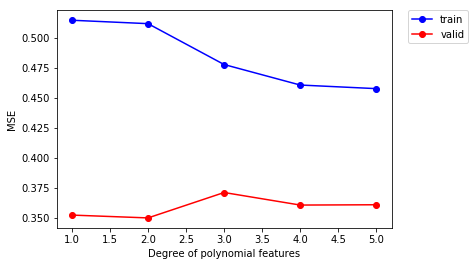

In [17]:
plot1 = plt.plot(deg_list, t_mse, '-ob', label = 'train')
plot2 = plt.plot(deg_list, v_mse, '-or', label = 'valid')
plt.ylabel("MSE")
plt.xlabel("Degree of polynomial features")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()